## Local Feature Importance

In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import balanced_accuracy_score

import shap

save_figures = True
figure_path = "../figures/evaluation/"
# df_init = pd.read_parquet("../data/init.parquet")
# df_before = pd.read_parquet("../data/before_split.parquet")
# df_train = pd.read_parquet("../data/prep_train.parquet")
# df_val = pd.read_parquet("../data/prep_val.parquet")
# df_test = pd.read_parquet("../data/prep_test.parquet")
df_tt_train = pd.read_parquet("../data/prep_tt_train.parquet")
df_tt_test = pd.read_parquet("../data/prep_tt_test.parquet")
# df_all = pd.read_parquet("../data/prep_all.parquet")

In [2]:
df_tt_train.head()

,Year_Y2015,Year_Y2016,Country_England,Country_Wales,Supermarket_Asda,Supermarket_Tesco Extra,Supermarket_Tesco Metro,Supermarket_Waitrose,Time_Evening,Time_Morning,...,YearCountryAge_Y2016EnglandAge_g2,YearCountryAge_Y2016EnglandAge_g3,YearCountryAge_Y2016WalesAge_g1,YearCountryAge_Y2016WalesAge_g2,YearCountryAge_Y2016WalesAge_g3,YearCountryAge_nan,ObsSize,FemaleN,MaleN,y
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.474255,-1.160118,0.858181,1
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,-0.474255,0.589356,-0.999109,1
2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.474255,0.589356,-0.999109,1
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.794531,0.589356,0.858181,1
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,-0.474255,-1.160118,0.858181,0


In [3]:
X_tt_train = df_tt_train.iloc[:,0:-1].to_numpy()
y_tt_train = df_tt_train["y"].to_numpy()

X_tt_test = df_tt_test.iloc[:,0:-1].to_numpy()
y_tt_test = df_tt_test["y"].to_numpy()

### Random Forest Classifier

In [4]:
feature_names = df_tt_train.columns[0:-1]

In [5]:
random_state = 132
RFC_grid = RandomForestClassifier(n_estimators = 100,
                                  random_state= random_state, 
                                  n_jobs = 1, 
                                  class_weight = "balanced")
RFC_grid

RandomForestClassifier(class_weight='balanced', n_jobs=1, random_state=132)

In [6]:
params_RFC = {'max_features': [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, None],
              'max_depth': [3, 4, 5, 6, 8, None],
              'min_samples_split': [2, 3, 4, 5, 6, 7]}

gridCV_rfc = GridSearchCV(estimator = RFC_grid, 
                          param_grid = params_RFC, 
                          scoring = 'balanced_accuracy', 
                          n_jobs = -2,
                          refit = True, 
                          cv = 5, 
                          verbose = 4)
gridCV_rfc

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced', n_jobs=1,
                                              random_state=132),
             n_jobs=-2,
             param_grid={'max_depth': [3, 4, 5, 6, 8, None],
                         'max_features': [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6,
                                          0.65, None],
                         'min_samples_split': [2, 3, 4, 5, 6, 7]},
             scoring='balanced_accuracy', verbose=4)

In [7]:
%%time 
gridCV_rfc.fit(X_tt_train, y_tt_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Wall time: 1min 39s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced', n_jobs=1,
                                              random_state=132),
             n_jobs=-2,
             param_grid={'max_depth': [3, 4, 5, 6, 8, None],
                         'max_features': [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6,
                                          0.65, None],
                         'min_samples_split': [2, 3, 4, 5, 6, 7]},
             scoring='balanced_accuracy', verbose=4)

In [8]:
y_pred_rfc = gridCV_rfc.predict(X_tt_test)
print(balanced_accuracy_score(y_tt_test, y_pred_rfc))

0.6891169977924945


In [9]:
gridCV_rfc.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=0.4,
                       min_samples_split=5, n_jobs=1, random_state=132)

### Shapley Additive Explanations (SHAP)

In [10]:
shap.initjs()
explainer = shap.explainers.Tree(gridCV_rfc.best_estimator_)
shap_values = explainer.shap_values(X_tt_test)
shap_values2 = explainer(X_tt_test)
print(np.shape(shap_values))

(2, 377, 85)


0.49924302480980154


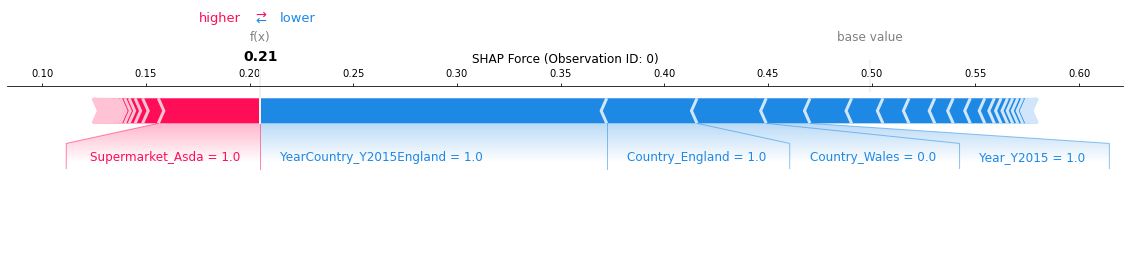

In [11]:
index = 0 # the index of the point to explain
print(explainer.expected_value[1]) # we explain class 0 predictions
shap.plots.force(explainer.expected_value[1], 
                shap_values[1][index,:], 
                features = X_tt_test[index,:],
                feature_names = feature_names, 
                show = False,
                matplotlib = True)

plt.title("SHAP Force (Observation ID: 0)")

# save_figures
if save_figures:
    fig_name = f"{figure_path}SHAP Force index 0"
    plt.savefig(f"{fig_name}.pdf", 
                dpi = 300, 
                bbox_inches="tight")
    plt.savefig(f"{fig_name}.png", 
                dpi = 300, 
                bbox_inches="tight")
    plt.savefig(f"{fig_name}.svg", 
                dpi = 300, 
                bbox_inches="tight")

plt.show()

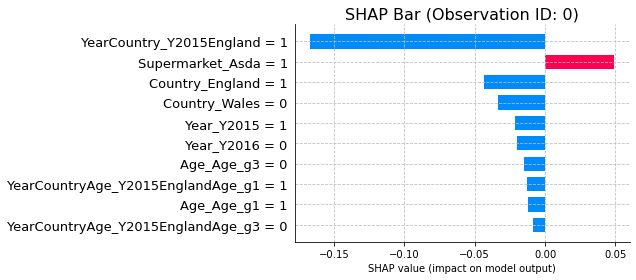

In [12]:
index = 0
shap.bar_plot(shap_values[1][index, :],
              max_display = 10, 
              show = False,
              features = X_tt_test[index,:],
              feature_names = feature_names)

plt.title("SHAP Bar (Observation ID: 0)", fontsize = 16)

plt.grid(linestyle = "dashed", 
            color = "#bfbfbf", axis = 'both')

# save_figures
if save_figures:
    fig_name = f"{figure_path}SHAP Bar index 0"
    plt.savefig(f"{fig_name}.pdf", 
                dpi = 300, 
                bbox_inches="tight")
    plt.savefig(f"{fig_name}.png", 
                dpi = 300, 
                bbox_inches="tight")
    plt.savefig(f"{fig_name}.svg", 
                dpi = 300, 
                bbox_inches="tight")
plt.show()

0.49924302480980154


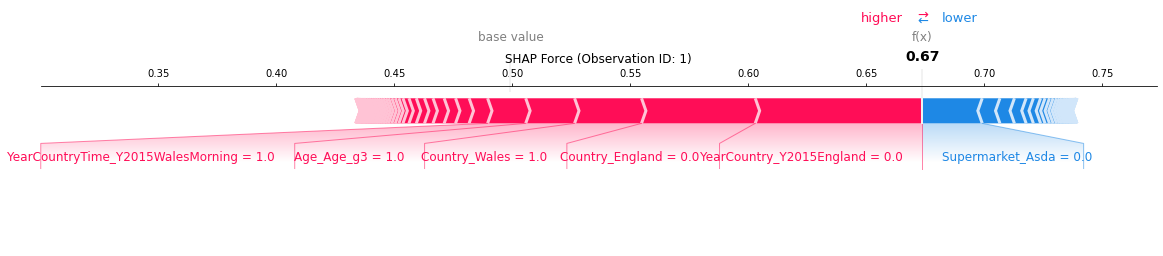

In [13]:
index = 1 # the index of the point to explain
print(explainer.expected_value[1]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[1], 
                shap_values[1][index,:], 
                features = X_tt_test[index,:],
                feature_names = feature_names, 
                matplotlib = True,
                show = False)

plt.title("SHAP Force (Observation ID: 1)")

# save_figures
if save_figures:
    fig_name = f"{figure_path}SHAP Force index 1"
    plt.savefig(f"{fig_name}.pdf", 
                dpi = 300, 
                bbox_inches="tight")
    plt.savefig(f"{fig_name}.png", 
                dpi = 300, 
                bbox_inches="tight")
    plt.savefig(f"{fig_name}.svg", 
                dpi = 300, 
                bbox_inches="tight")
    
plt.show()

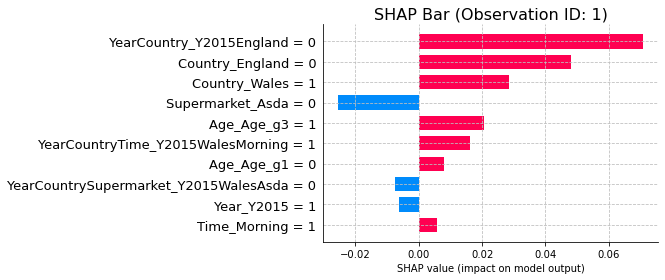

In [14]:
index = 1
shap.bar_plot(shap_values[1][index, :],
              max_display = 10,
              features = X_tt_test[index,:],
              feature_names = feature_names, 
              show = False)

plt.title("SHAP Bar (Observation ID: 1)", fontsize = 16)

plt.grid(linestyle = "dashed", 
            color = "#bfbfbf", axis = 'both')

# save_figures
if save_figures:
    fig_name = f"{figure_path}SHAP Bar index 1"
    plt.savefig(f"{fig_name}.pdf", 
                dpi = 300, 
                bbox_inches="tight")
    plt.savefig(f"{fig_name}.png", 
                dpi = 300, 
                bbox_inches="tight")
    plt.savefig(f"{fig_name}.svg", 
                dpi = 300, 
                bbox_inches="tight")
    
plt.show()

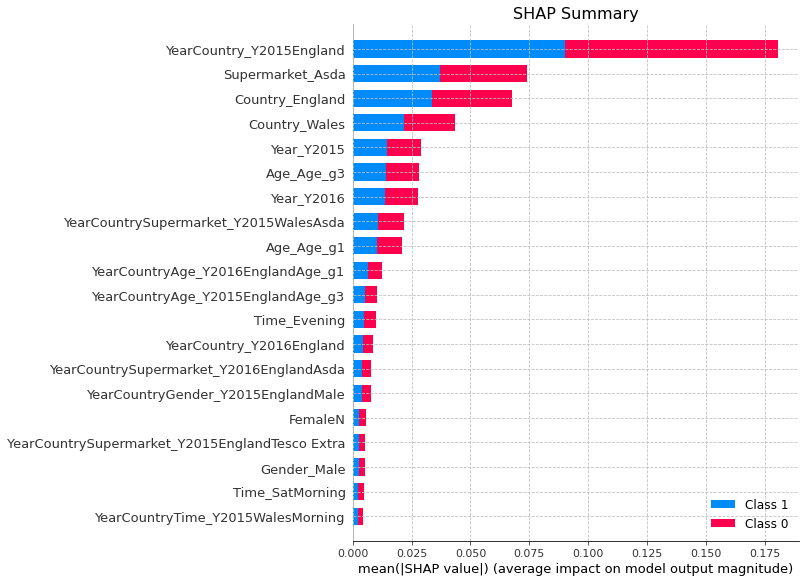

In [15]:
shap.summary_plot(shap_values, 
                  X_tt_test,
                  feature_names = feature_names, 
                  show = False)

plt.title("SHAP Summary", fontsize = 16)

plt.grid(linestyle = "dashed", 
            color = "#bfbfbf", axis = 'both')

# save_figures
if save_figures:
    fig_name = f"{figure_path}SHAP Summary"
    plt.savefig(f"{fig_name}.pdf", 
                dpi = 300, 
                bbox_inches="tight")
    plt.savefig(f"{fig_name}.png", 
                dpi = 300, 
                bbox_inches="tight")
    plt.savefig(f"{fig_name}.svg", 
                dpi = 300, 
                bbox_inches="tight")
    
plt.show()